# ```uavsar_pytools``` Tutorial

In this notebook, we will display the basic functionality of using ```asf_search``` to find UAVSAR data products, and ```uavsar_pytools``` convert those products in analysis ready GeoTiifs. UAVSAR files come in a flat binary format, which are not ready for analysis. This package allows for the systematic conversion of binary files into GeoTiffs using information from the UAVSAR annoation file.

In [1]:
import asf_search as asf
from uavsar_pytools.UavsarImage import UavsarImage #single image class
from uavsar_pytools.uavsar_tools import grd_tiff_convert #single image class
from uavsar_pytools.UavsarScene import UavsarScene # binary convert to .tiffs
import os  # for chdir, getcwd, path.basename, path.exists
from datetime import datetime
import progressbar
from tqdm import tqdm
import logging
import glob
import requests
import zipfile
#from uavsar_pytools.convert import convert_image
#from uavsar_pytools.download import download_image

# for map to generate wkt
from folium import Map
from folium.plugins import Draw
import geopandas as gpd

# plotting libraries
import numpy as np #for log10, mean, percentile, power
import rasterio as rio
from rasterio.plot import show # plotting raster data
from rasterio.plot import show_hist #histograms of raster data
import matplotlib.pyplot as plt 

### Finding UAVSAR data

UAVSAR data is located in multiple places online 

### Create Folium map to generate at WKT file

The ```asf_search``` package uses the Well-known text or [WKT](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry) files to indentify areas of interest (AOI) to search thier database. The [Folium](https://python-visualization.github.io/folium/#:~:text=folium%20makes%20it%20easy%20to,as%20markers%20on%20the%20map.) map created below allows users to generate a WKT by drawing a polygon directly on the map and exporting it to thier local machine. instead of having to write it out by hand. 

Another tool for generating WKT files is the [ASF Vertex](https://search.asf.alaska.edu/#/) platform.

The [UAVSAR Data Search](https://uavsar.jpl.nasa.gov/cgi-bin/data.pl) shows the extent of all UAVSAR swaths. This is a good place to start to base your area of interest (AOI) search on using the Folium map.

In [18]:
# show map\n
m = Map()
draw = Draw(export = True, filename = 'asf_wkt.geojson')
draw.add_to(m)
m

In [19]:
wkt = gpd.read_file('/Users/jacktarricone/Downloads/asf_wkt (13).geojson').to_wkt().loc[0, 'geometry']
print(wkt)

POLYGON ((-111.665039 40.534677, -111.665039 40.833554, -111.180267 40.833554, -111.180267 40.534677, -111.665039 40.534677))


In [20]:
# define search parameters for sierra flight line
start_date = datetime.strptime('2021-02-14 11:00:00', '%Y-%m-%d %H:%M:%S') 
end_date = datetime.strptime('2021-02-15 11:00:00', '%Y-%m-%d %H:%M:%S') 

## Seach for data
-use asf search, talk about all the parameters that can be used for search
-show different types of processing, state that GRD is important
-

In [21]:
# search for data
results = asf.search(platform = 'UAVSAR',
                     processingLevel = (['INTERFEROMETRY_GRD']),
                     intersectsWith = wkt,
                     start = start_date,
                     end = end_date)

print(f'{len(results)} product(s) found')

2 product(s) found


In [22]:
# describe this whole "class" thing...
type(first)

asf_search.ASFProduct.ASFProduct

In [23]:
# pull out three search results and test print the first one
first = results[0]
print(first.properties)

{'beamModeType': 'RPI', 'browse': ['https://datapool.asf.alaska.edu/BROWSE/UA/stlake_27129_21011-012_21014-001_0013d_s01_L090HH_01.cor.png', 'https://datapool.asf.alaska.edu/BROWSE/UA/stlake_27129_21011-012_21014-001_0013d_s01_L090HH_01.hgt.png', 'https://datapool.asf.alaska.edu/BROWSE/UA/stlake_27129_21011-012_21014-001_0013d_s01_L090HV_01.cor.png', 'https://datapool.asf.alaska.edu/BROWSE/UA/stlake_27129_21011-012_21014-001_0013d_s01_L090HV_01.hgt.png', 'https://datapool.asf.alaska.edu/BROWSE/UA/stlake_27129_21011-012_21014-001_0013d_s01_L090VH_01.cor.png', 'https://datapool.asf.alaska.edu/BROWSE/UA/stlake_27129_21011-012_21014-001_0013d_s01_L090VH_01.hgt.png', 'https://datapool.asf.alaska.edu/BROWSE/UA/stlake_27129_21011-012_21014-001_0013d_s01_L090VV_01.cor.png', 'https://datapool.asf.alaska.edu/BROWSE/UA/stlake_27129_21011-012_21014-001_0013d_s01_L090VV_01.hgt.png'], 'bytes': '1411726315', 'faradayRotation': None, 'fileID': 'UA_stlake_27129_21011-012_21014-001_0013d_s01_L090_01-INT

## Define URLs for Download


In [24]:
# define the URLs and print, decribe this functionality is within the ASFproduct class
first_url = first.properties['url']
print(first_url)

https://datapool.asf.alaska.edu/INTERFEROMETRY_GRD/UA/stlake_27129_21011-012_21014-001_0013d_s01_L090_01_int_grd.zip


In [26]:
# define outpout dir and list files
os.chdir('/Users/jacktarricone/Desktop/zach_test/slc/')
output_dir = '/Users/jacktarricone/Desktop/zach_test/slc/'

In [27]:
# define image to download
# download_image(url = first_url, output_dir = output_dir)
scene = UavsarScene(url = first_url, work_dir='./data/imgs/')
scene.url_to_tiffs()

Unzipping: 100%|████████████████████████████| 20/20 [00:30<00:00,  1.51s/file]


# Test Plots
Now that the data has been downloaded and converted to GeoTiffs, let's test plot to make sure everything worked properly.

In [43]:
# search for unw and ann files for download test
# os.chdir('/Users/jacktarricone/Desktop/zach_test/slc/data')
unw = glob.glob(os.path.abspath("data/imgs/tiffs/*HH*hgt.grd.tiff"))
print(unw[0])

/Users/jacktarricone/Desktop/zach_test/slc/data/imgs/tiffs/stlake_27129_21011-012_21014-001_0013d_s01_L090HH_01.hgt.grd.tiff


In [44]:
unw_rast = rio.open(unw[0])
meta_data = unw_rast.profile
print(meta_data)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 8895, 'height': 4868, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(5.556e-05, 0.0, -111.89361744,
       0.0, -5.556e-05, 40.75203768), 'tiled': False, 'interleave': 'band'}


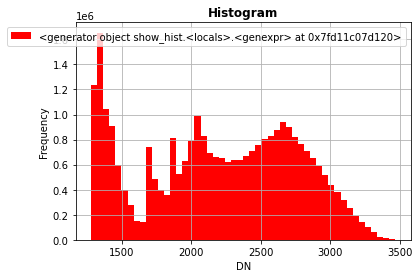

In [45]:
show_hist(unw_rast, bins = 50)

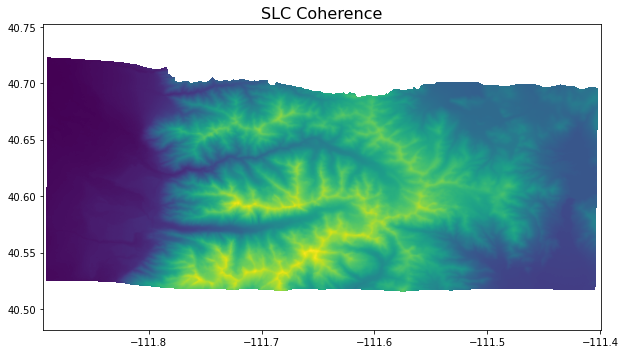

In [46]:
fig, ax = plt.subplots(figsize = (10,7))
ax.set_title("SLC Coherence",fontsize = 16);
show((unw_rast, 1), cmap = 'viridis'); # info from histogram